In [1]:
from datetime import datetime
from datetime import timedelta

from pymongo import MongoClient
from pandas import DataFrame
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tushare as ts
from WindPy import w
w.start();


import fdm

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2017 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


In [ ]:
pro = ts.pro_api()

In [2]:
client = MongoClient("192.168.56.1",27017)

In [3]:
tushare = fdm.Tushare(client)
db = tushare.daily_basic()

In [5]:
tushare.db.client

TypeError: 'MongoClient' object is not callable

In [ ]:
MSCI_CN = {'CNY': '302400L.MI',
           'USD': '302400.MI'}
data = w.wsd("302400L.MI", "close", "1999-12-20", "2019-08-26", "",usedf=True)[1]
data.sort_index(inplace = True)
data.to_json('msci_china.bz2')

In [ ]:
data = w.wsd("000300.SH", "close", "1999-12-20", "2019-08-26", "",usedf=True)[1]
data.sort_index(inplace = True)
data.to_json('hs300.bz2')

In [ ]:
index = pd.read_json('msci_china.bz2').sort_index().dropna()
index_ror = index.pct_change()

In [ ]:
index = pd.read_json('hs300.bz2').sort_index().dropna()
index_ror = index.pct_change()

In [ ]:
clean = fdm.CleanData(client)
cdb = clean.pricing()

tdb = fdm.TempDB(client)
actp = tdb['actPrice']

# Build active price vs CSI300
def actprice(code):
    start_date = datetime(2002,1,4)
    close = cdb.query({'code':code,'date':{'$gt':start_date}},['code','date','close'])
    if not close.empty:
        close.set_index(['date'],inplace = True)
        close = close.sort_index().copy()
        close['close'] = close['close'].pct_change()-index_ror['CLOSE']
        close.iat[0,1] = 0
        close['act_price'] = np.cumprod(close['close']+1)
        close.rename(columns={'close':'act_ror'},inplace=True)
        close.reset_index(inplace=True)
        return close
    else:
        return DataFrame

actp.drop()
codes = cdb.stock_codes()
for code in codes:
    df = actprice(code)
    actp.insert_many(df)



In [174]:
actp.create_indexs(['date','code'])

0

In [178]:
tdb = fdm.TempDB(client)
actp = tdb['actPrice']
mratio = tdb['mmRatio']

def maxmin_ratio(ts):
    maxv = np.max(ts)
    minv = np.min(ts)
    pt = ts[-1]
    return (minv-pt)/(minv-maxv)

#codes = actp.distinct('code')
mratio.drop()
for code in codes:
    data = actp.query({'code':code})
    data.set_index('date',inplace=True)
    data.sort_index(inplace=True)

    periods = [3,6,9,12,24,36]
    for n in periods:
        data['mm_ratio_'+str(n)] = data['act_price'].sort_index(ascending = False).rolling(20*n).apply(maxmin_ratio, raw=True)
    
    data.reset_index(inplace=True)
    mratio.insert_many(data)

4121 records inserted into tempDB.mmRatio
4073 records inserted into tempDB.mmRatio
13 records inserted into tempDB.mmRatio
3946 records inserted into tempDB.mmRatio
3837 records inserted into tempDB.mmRatio
4082 records inserted into tempDB.mmRatio
3578 records inserted into tempDB.mmRatio
3902 records inserted into tempDB.mmRatio
4075 records inserted into tempDB.mmRatio
3292 records inserted into tempDB.mmRatio
4072 records inserted into tempDB.mmRatio
4169 records inserted into tempDB.mmRatio
548 records inserted into tempDB.mmRatio
4136 records inserted into tempDB.mmRatio
4131 records inserted into tempDB.mmRatio
3163 records inserted into tempDB.mmRatio
4068 records inserted into tempDB.mmRatio
3903 records inserted into tempDB.mmRatio
3768 records inserted into tempDB.mmRatio
4181 records inserted into tempDB.mmRatio
3911 records inserted into tempDB.mmRatio
3138 records inserted into tempDB.mmRatio
4159 records inserted into tempDB.mmRatio
4183 records inserted into tempDB.mmR

In [179]:
mratio.create_indexs(['date','code'])

0

In [173]:
data = actp.query({'code':'000001.SZ'})
data.set_index('date',inplace=True)
data.sort_index(inplace=True)

In [ ]:
['CSI','SSE','SZSE','SW']
indexes = pro.index_basic(market='SW')
indexes.head()

# Factor base

In [5]:
# Size factor

from fdm import Tushare
from fdm import CleanData

# Var
# client = self.get_client()
client = client
startdate = datetime(2019,1,1)
enddate = datetime(2019,2,1)
category = 'mv'
q=0.5

catcode = {'mv': 'total_mv', 'fmv': 'circ_mv'}

# Init database
tdb = Tushare(client).daily_basic()
cdb = CleanData(client).pricing()

# Get category score
catdata = tdb.query({'trade_date': {'$gt': startdate, '$lte': enddate}},
                    projection=['ts_code', 'trade_date', catcode[category]])
catdata = catdata.pivot(
    index='trade_date', columns='ts_code', values=catcode[category])
catdata.sort_index(inplace=True)

# Split stock codes by category score
def split_list_by_quantile(ts):
    low = ts[ts.quantile(q)>ts].index
    high = ts[ts.quantile(1-q)<=ts].index
    return pd.Series({'low':list(low),'high':list(high)})
split_list = catdata.apply(split_list_by_quantile,axis = 1)

# Get return data


In [28]:
stocklist = split_list.at['2019-01-02','high']
cdb.query({'code':{'$in':stocklist},'date':datetime(2019,1,2)})#{'$gt': startdate, '$lte': enddate}

,code,date,open,high,low,close,vwap,adj_factor
0,000001.SZ,2019-01-02,1014.41109,1017.65202,989.56396,992.80489,998.811600,108.031
1,000002.SZ,2019-01-02,3399.77844,3436.87212,3376.95156,3409.76520,3404.162837,142.668
2,000006.SZ,2019-01-02,177.29068,179.68650,174.55260,176.26390,177.186115,34.226
3,000008.SZ,2019-01-02,86.64975,87.09525,84.86775,86.42700,86.297288,22.275
4,000009.SZ,2019-01-02,32.03340,32.47524,31.37064,31.66520,31.785331,7.364
5,000011.SZ,2019-01-02,32.21840,33.16394,32.21840,32.67366,32.704975,3.502
6,000012.SZ,2019-01-02,94.73058,95.91768,94.49316,94.49316,95.066429,23.742
7,000016.SZ,2019-01-02,68.60376,69.45072,68.18028,69.02724,68.773222,21.174
8,000019.SZ,2019-01-02,29.01948,29.50584,28.81683,28.85736,29.100921,4.053
9,000021.SZ,2019-01-02,80.09886,80.09886,78.43878,78.57712,78.985759,13.834


In [32]:
DataFrame(cdb.col.col.find({'code':{'$in':stocklist},'date':{'$lte':datetime(2019,1,2)}}).sort([('date',-1)]).limit(2))

,_id,code,date,open,high,low,close,vwap,adj_factor
0,5d649f632f624948997312c6,300104.SZ,2019-01-02,96.46992,96.46992,94.70952,96.46992,96.399848,35.208
1,5d649f632f62494899731169,000939.SZ,2019-01-02,22.54336,22.92224,21.97504,22.54336,22.418233,18.944


In [47]:
df = cdb.query({'code':'000001.SZ'})
df = df.set_index('date')
df = df.sort_index()

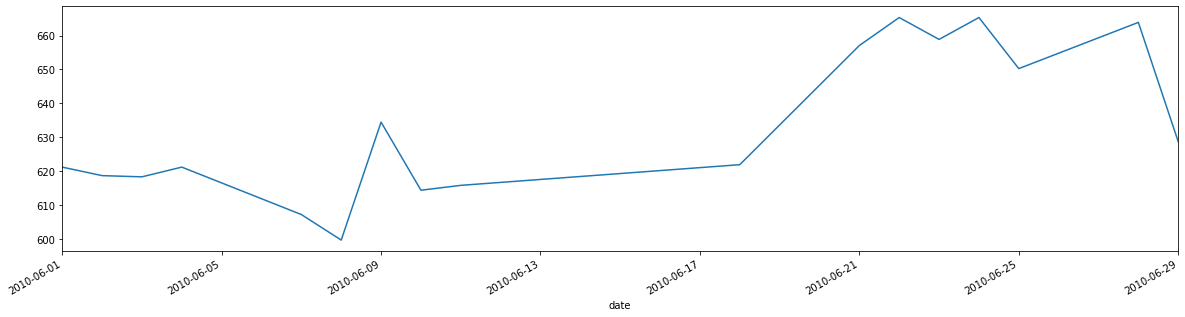

In [58]:

df['close']['2010-06-01':'2010-09-01'].plot(figsize=(20,5))

In [60]:
df['close']['2010-06-01':'2010-09-01'].pct_change()

date
2010-06-01         NaN
2010-06-02   -0.004046
2010-06-03   -0.000580
2010-06-04    0.004646
2010-06-07   -0.022543
2010-06-08   -0.012419
2010-06-09    0.058084
2010-06-10   -0.031692
2010-06-11    0.002338
2010-06-18    0.009913
2010-06-21    0.056582
2010-06-22    0.012568
2010-06-23   -0.009714
2010-06-24    0.009809
2010-06-25   -0.022666
2010-06-28    0.020983
2010-06-29   -0.053002
Name: close, dtype: float64